In [6]:
import pandas as pd
from datetime import datetime
import iso3166
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [7]:
#Adds country identifier
def to_iso3_jhu(country): 
    
    iso3_jhu = {'Bolivia':'BOL', 'Brunei':'BRN', 'Burma':'MMR', 'Congo (Brazzaville)':'COG',
       'Congo (Kinshasa)':'COD', "Cote d'Ivoire":'CIV', 'Iran':'IRN', 'Korea, South':'KOR',
       'Laos':'LAO', 'Moldova':'MDA', 'Russia':'RUS', 'Syria':'SYR', 'Taiwan*':'TWN', 'Tanzania':'TZA',
       'United Kingdom':'GBR', 'Venezuela':'VEN', 'Vietnam':'VNM', 'West Bank and Gaza':'PSE'}
    
    if country in iso3_jhu.keys():
        return iso3_jhu[country]
    else:
        try:
            return iso3166.countries.get(country).alpha3
        except:
            raise ValueError('Invalid country')
            
def from_iso3_jhu(iso3): 
    
    iso3_jhu = {'Bolivia':'BOL', 'Brunei':'BRN', 'Burma':'MMR', 'Congo (Brazzaville)':'COG',
       'Congo (Kinshasa)':'COD', "Cote d'Ivoire":'CIV', 'Iran':'IRN', 'Korea, South':'KOR',
       'Laos':'LAO', 'Moldova':'MDA', 'Russia':'RUS', 'Syria':'SYR', 'Taiwan*':'TWN', 'Tanzania':'TZA',
       'United Kingdom':'GBR', 'Venezuela':'VEN', 'Vietnam':'VNM', 'West Bank and Gaza':'PSE'}
    
    iso3_jhu_inv = {iso3_jhu[k] : k for k in iso3_jhu}
    
    if iso3 in iso3_jhu.keys():
        return iso3_jhu[iso3]
    else:
        try:
            return iso3166.countries.get(iso3).name
        except:
            raise ValueError('Invalid country')

In [8]:
#Downloads data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url, sep=',')
df = df.drop(columns=['Province/State', 'Lat','Long']).groupby('Country/Region').sum().T
df.reset_index(inplace=True)
df.rename(columns={'index':'date',"Country/Region":'country'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df = pd.melt(df, id_vars = 'date').rename(columns={'value':'confirmed'})
df['new'] = df['confirmed'].diff()
df.loc[df['date']==df['date'].min(), 'new'] = 0

#Drops datasets of non-countries
df = df.drop(df[df['Country/Region'].isin(['MS Zaandam', 'Diamond Princess'])].index)

#Adds iso3166 code to df, including non-standard cases
df['code'] = df['Country/Region'].apply(to_iso3_jhu)

#Downloads population data and adds to df
url_pop = 'https://raw.githubusercontent.com/datasets/population/master/data/population.csv' 
df_pop = pd.read_csv(url_pop)
df_pop = df_pop[df_pop.Year == 2018][['Country Code','Value']].rename(columns={'Country Code':'code', 'Value':'pop'})

df = df.merge(df_pop, on='code')

#Obtains plottable observables
df['new_1M'] = 1e6*df['new']/df['pop']

In [9]:
#Parameters
plot_observable = 'new_1M'
value_zmax_cur = 20 #Initial zmax for a changing definition
average_window = 5
str_title = "New COVID19 cases per 1M habitants (smoothed 5 days)"

#Calculates rolling df
plot_observable_rolling = plot_observable + '_rolling'
df_rolling = df.set_index('date').groupby('code').rolling(average_window)[plot_observable].mean().reset_index().rename(columns={plot_observable:plot_observable_rolling})
df_rolling['country'] = df_rolling['code'].apply(from_iso3_jhu)

df_plot = df_rolling

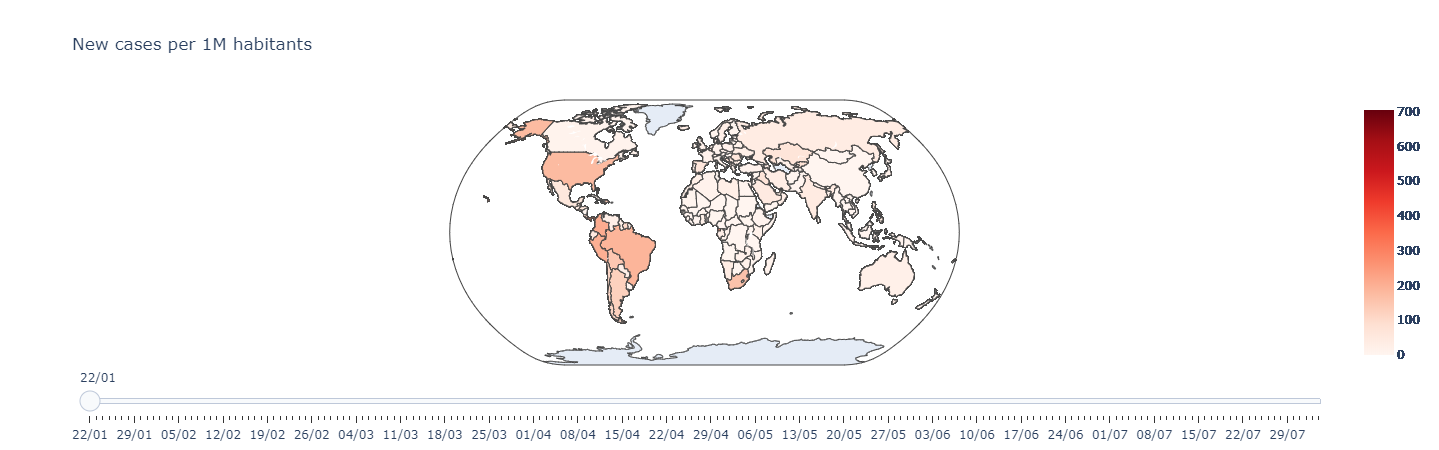

In [11]:
#Formats data for the slider
data_slider = []
dates = df.date.unique()
date_i = pd.to_datetime(dates.min())

for date in dates:
      
    #Sets Zmax
    if value_zmax_cur < df_plot[df_plot.date == date][plot_observable_rolling].max():
        value_zmax_cur = df_plot[df_plot.date == date][plot_observable_rolling].max()
    
    data_day = df_plot[df_plot.date == date]
    
    data_day = dict(
        type = 'choropleth',
        locations = data_day['code'],
        z = data_day[plot_observable_rolling],
        text = data_day['country'],
        zmax = value_zmax_cur,
        zmin = 0,
        colorscale = 'Reds',
    )
    data_slider.append(data_day)

#Builds slider
steps = []
for i in range(len(data_slider)):
    
    str_date = (date_i + pd.to_timedelta(i,'day')).strftime("%d/%m")
    
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label = str_date,
               )
    step['args'][1][i] = True
    steps.append(step)

sliders = [dict(active=0, pad={"t": 1}, steps=steps)]  

# Sets up layout and data dict
layout = dict(
    geo=dict(scope='world',projection={'type': 'natural earth'}),
    sliders=sliders,
    title=go.layout.Title(text=str_title)
)

plot_dict = dict(data=data_slider, layout=layout) 

# Plots it in the notebook. Requires plotly jupyter extensions (node.js)
plotly.offline.iplot(plot_dict)

#Saves to .html and  opens it
#offline.plot(plot_dict, auto_open=True, filename='new_cases_covid19.html', validate=True)